# Word–gender Association Scores using Normalized PMI (nPMI)

In [2]:
# import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kanika/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# import dataset
data = pd.read_csv('WikiBioReformatted_balanced_100k.tsv', sep="\t")
data.head()

,text,person,gender,split
0,"federica de bortoli ( born november 9 , 1976 i...",federica de bortoli,woman,train
1,janice maree edwards ( born 2 february 1962 ) ...,maree edwards,woman,train
2,dejan antić ( serbian cyrillic : Дејан Антић ;...,dejan antić,man,train
3,stephanie pui-mun law ( born 1976 ) is an amer...,stephanie pui-mun law,woman,train
4,perlita neilson ( born margaret phillipa sowde...,perlita neilson,woman,train


In [25]:
text = data[data['person'] == 'd.h. peligro']['text'].iloc[0]
num_words = len(text.split())
print(num_words)

566


In [4]:
# extract only the necessary columns
data = data[['text', 'gender']]
data.head()

,text,gender
0,"federica de bortoli ( born november 9 , 1976 i...",woman
1,janice maree edwards ( born 2 february 1962 ) ...,woman
2,dejan antić ( serbian cyrillic : Дејан Антић ;...,man
3,stephanie pui-mun law ( born 1976 ) is an amer...,woman
4,perlita neilson ( born margaret phillipa sowde...,woman


### Tokenization and Filtering

In [5]:
# tokenize the text data
data['text'] = data['text'].astype(str).str.lower().str.split()
data.head()

,text,gender
0,"[federica, de, bortoli, (, born, november, 9, ...",woman
1,"[janice, maree, edwards, (, born, 2, february,...",woman
2,"[dejan, antić, (, serbian, cyrillic, :, дејан,...",man
3,"[stephanie, pui-mun, law, (, born, 1976, ), is...",woman
4,"[perlita, neilson, (, born, margaret, phillipa...",woman


In [6]:
# remove english stopwords via NLTK
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in stop_words])
data.head()

,text,gender
0,"[federica, de, bortoli, (, born, november, 9, ...",woman
1,"[janice, maree, edwards, (, born, 2, february,...",woman
2,"[dejan, antić, (, serbian, cyrillic, :, дејан,...",man
3,"[stephanie, pui-mun, law, (, born, 1976, ), am...",woman
4,"[perlita, neilson, (, born, margaret, phillipa...",woman


In [7]:
# remove punctuations that are part of string.punctuation
import string
punctuations = set(string.punctuation)
data['text'] = data['text'].apply(lambda x: [word for word in x if word not in punctuations])
data.head()

,text,gender
0,"[federica, de, bortoli, born, november, 9, 197...",woman
1,"[janice, maree, edwards, born, 2, february, 19...",woman
2,"[dejan, antić, serbian, cyrillic, дејан, антић...",man
3,"[stephanie, pui-mun, law, born, 1976, american...",woman
4,"[perlita, neilson, born, margaret, phillipa, s...",woman


In [8]:
# ignore tokens with total corpus frequency < 10
from collections import Counter

# flatten the list of lists of words into a single list of words
all_words = [word for sublist in data['text'] for word in sublist]
word_counts = Counter(all_words)

# ignore tokens with total corpus frequency < 10
frequent_words = {word for word, count in word_counts.items() if count >= 10}
data['text'] = data['text'].apply(lambda x: [word for word in x if word in frequent_words])
data.head()

,text,gender
0,"[federica, de, born, november, 9, 1976, rome, ...",woman
1,"[janice, maree, edwards, born, 2, february, 19...",woman
2,"[dejan, serbian, cyrillic, born, 1968, serbian...",man
3,"[stephanie, law, born, 1976, american, painter...",woman
4,"[neilson, born, margaret, 11, june, 1933, --, ...",woman


### Compute Association with nPMI

In [9]:
# N be the total number of tokens across all biographies in the dataset
N = sum(len(text) for text in data['text'])
print(N)

6066521


In [10]:
# total token count of word w across all documents
def total_token_count(word):
    return sum(text.count(word) for text in data['text'])
print(total_token_count('november'))

11112


In [11]:
# for a gender g, the set of documents within that gender
def documents_by_gender(gender):
    return data[data['gender'] == gender]
print(documents_by_gender('woman').head())

                                                text gender
0  [federica, de, born, november, 9, 1976, rome, ...  woman
1  [janice, maree, edwards, born, 2, february, 19...  woman
3  [stephanie, law, born, 1976, american, painter...  woman
4  [neilson, born, margaret, 11, june, 1933, --, ...  woman
5  [anna, margaret, michelle, english, singer-son...  woman


In [13]:
len(documents_by_gender('woman'))

50000

In [14]:
len(documents_by_gender('man'))

50000

In [77]:
# number of tokens in document with gender g
def total_tokens_by_gender(gender):
    docs = documents_by_gender(gender)
    return sum(len(text) for text in docs['text'])
print(total_tokens_by_gender('woman'))

2933648


In [78]:
# total token count of word w inside documents of gender g
def total_tokens_by_word_and_gender(word, gender):
    docs = documents_by_gender(gender)
    return sum(text.count(word) for text in docs['text'])
print(total_tokens_by_word_and_gender('november', 'woman'))

5104


In [79]:
# calculate PMI between a word w and gender g
def calculate_pmi(w, g):
    numerator = N * total_tokens_by_word_and_gender(w, g)
    if numerator == 0:
        return None
    denominator = total_token_count(w) * total_tokens_by_gender(g)   
    pmi = np.log2(numerator / denominator)
    return pmi
print(calculate_pmi('intelligent', 'woman'))   

-0.4513973824111597


In [80]:
# calculate nPMI to account for relative frequency of words
def calculate_npmi(w, g):
    pmi = calculate_pmi(w, g)
    c_wg = total_tokens_by_word_and_gender(w, g)

    if pmi is None or c_wg == 0:
        return None
    
    denominator = -np.log2(c_wg / N)
    npmi = pmi / denominator
    if denominator == 0:
        return None

    return npmi
print(calculate_npmi('intelligent', 'woman'))

-0.02553953329243522


### Plot and Analyze Top Associations

In [81]:
# Analyze top 30 tokens by nPMI for "female" and "male"
def top_npmi_tokens(gender, top_n=30):
    unique_words = set(word for sublist in data['text'] for word in sublist)
    npmi_scores = {}

    for word in unique_words:
        npmi = calculate_npmi(word, gender)
        if npmi is not None:
            npmi_scores[word] = npmi

    # Return top N tokens by nPMI score
    sorted_tokens = sorted(npmi_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_tokens[:top_n]

top_tokens_female = top_npmi_tokens('woman')
top_tokens_male = top_npmi_tokens('man')

/var/folders/h6/93p_2snd3bl3v008snqlzq7m0000gn/T/ipykernel_68740/3246238461.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=female_scores, y=female_words, palette='Reds_d')


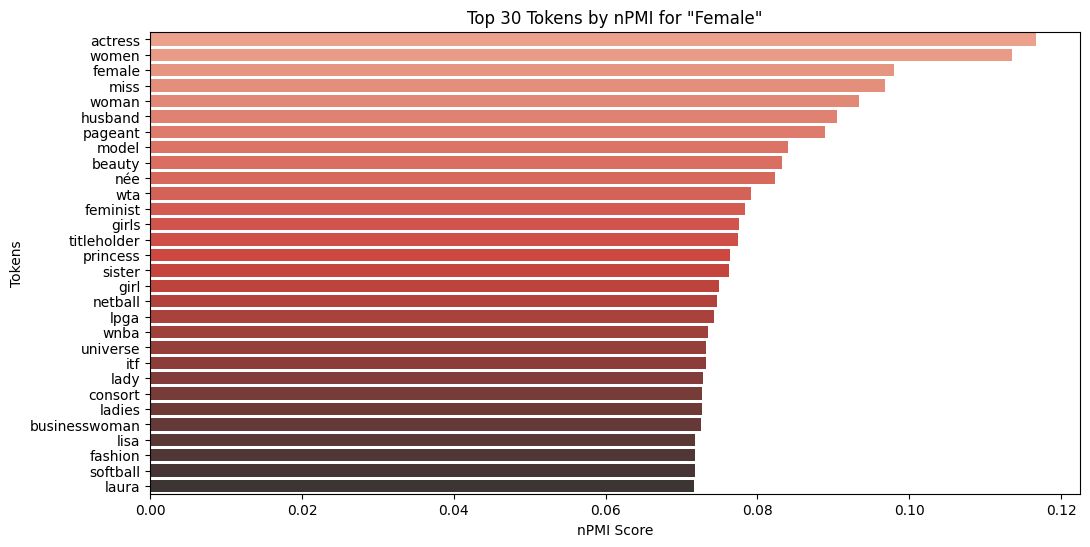

/var/folders/h6/93p_2snd3bl3v008snqlzq7m0000gn/T/ipykernel_68740/3246238461.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=male_scores, y=male_words, palette='Blues_d')


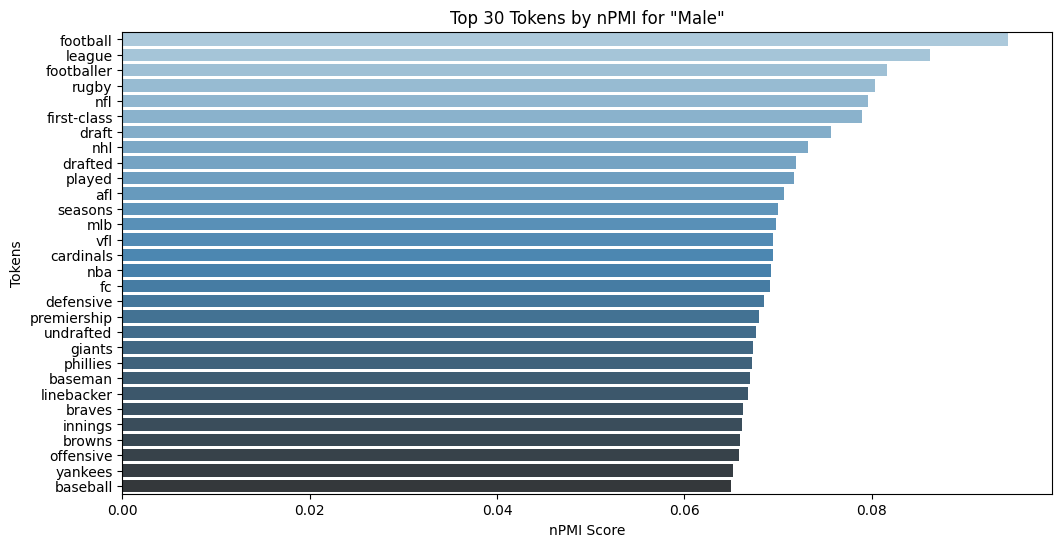

In [82]:
# Plot top 30 tokens

# Female top tokens
female_words, female_scores = zip(*top_tokens_female)
plt.figure(figsize=(12, 6))
sns.barplot(x=female_scores, y=female_words, palette='Reds_d')
plt.title('Top 30 Tokens by nPMI for "Female"')
plt.xlabel('nPMI Score')
plt.ylabel('Tokens')
plt.show()      

# Male top tokens
male_words, male_scores = zip(*top_tokens_male)
plt.figure(figsize=(12, 6))
sns.barplot(x=male_scores, y=male_words, palette='Blues_d')
plt.title('Top 30 Tokens by nPMI for "Male"')
plt.xlabel('nPMI Score')
plt.ylabel('Tokens')
plt.show()  